# Comparative Analysis of Structured vs Baseline LDA

This notebook loads `processed_data.csv` and performs topic modeling on two text inputs:
- **Structured approach:** Using the LLM-based structured text (column `structured_text`)
- **Baseline approach:** Using the preprocessed raw text (column `processed_text`)

We will train LDA models for each approach and evaluate them using:
- **Topic Coherence:** via Gensim’s CoherenceModel (e.g. using the `c_v` metric)
- **Topic Diversity:** computed as the ratio of unique words in top topics vs. total words
- **Perplexity:** based on the LDA model’s log perplexity on the corpus

We then generate interactive pyLDAvis visualizations, topic word clouds, analyze document–topic distributions,
and compare the metrics across both approaches.


## 1. Setup and Data Loading


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models
from gensim.models import CoherenceModel
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Download stopwords if needed
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Load the processed data
df = pd.read_csv("../results/fixed_processed_data.csv")
print("Data shape:", df.shape)
# Take a look at the first few rows
df.head()



Data shape: (4080, 11)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sammucyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,themes,emotional_tone,concerns,cognitive_patterns,social_context,original_text,id,structured_text,structured_tokens,processed_text,baseline_tokens
0,"['animal welfare', 'family dynamics', 'communi...",negative,"['potential animal abuse', 'impact on family r...","['catastrophizing', 'all-or-nothing thinking',...","['relationship with sister', 'relationship wit...",How do I confront my sister about this? I'm a ...,7,"THEMES: animal welfare, family dynamics, commu...","['THEMES', 'animal', 'welfare', 'family', 'dyn...",how do i confront my sister about this im a m ...,"['confront', 'sister', 'month', 'old', 'ridgeb..."
1,"['perception of reality', 'anxiety', 'mental c...",negative,"['fragility of reality perception', 'anxiety',...","['catastrophizing', 'dissociation', 'avoidance']","['self-perception', 'internal struggle', 'rela...",Does anyone ever feel like their perception of...,10,"THEMES: perception of reality, anxiety, mental...","['themes', 'perception', 'reality', 'anxiety',...",does anyone ever feel like their perception of...,"['anyone', 'ever', 'perception', 'reality', 'f..."
2,"['identity crisis', 'loss of ambition', 'lonel...",negative,"['identity confusion', 'loss of motivation', '...","['catastrophizing', 'all-or-nothing thinking',...","['feelings of isolation', 'lack of connection ...","I dont know who I am I have no values, i have ...",18,"THEMES: identity crisis, loss of ambition, lon...","['THEMES', 'identity', 'crisis', 'loss', 'ambi...",i dont know who i am i have no values i have n...,"['value', 'desire', 'anything', 'lose', 'ambit..."
3,"['optimism', 'hope', 'new beginnings', 'opport...",positive,[],"['positive outlook', 'future-oriented thinking']",[],I hope by the end of this year nobody says “wo...,26,"THEMES: optimism, hope, new beginnings, opport...","['THEMES', 'optimism', 'hope', 'new', 'beginni...",i hope by the end of this year nobody says wow...,"['hope', 'end', 'year', 'nobody', 'say', 'wow'..."
4,"['religion and mental health', 'mother-child r...",negative,"['feelings of worthlessness', 'fear of eternal...","['catastrophizing', 'black-and-white thinking'...","['religious upbringing', ""family's belief syst...","My mom said that if I commit suicide, I'll go ...",29,"THEMES: religion and mental health, mother-chi...","['THEMES', 'religion', 'mental', 'health', 'mo...",my mom said that if i commit suicide ill go to...,"['mom', 'say', 'commit', 'suicide', 'ill', 'he..."


## 2. Preprocessing and Tokenization

We define a simple tokenizer function. Here, we remove punctuation, numbers, and stop words.
You may refine this preprocessing as required.

In [19]:
def clean_and_tokenize(text):
    # Remove category markers
    markers = ['THEMES:', 'EMOTION:', 'COGNITIVE:', 'CONCERNS:', 'KEYWORDS:', 'SOCIAL CONTEXT:']
    for marker in markers:
        text = re.sub(marker, '', text, flags=re.IGNORECASE)
    
    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    
    # Remove short words and stopwords
    tokens = [word for word in tokens if len(word) > 2 and word not in STOPWORDS]
    return tokens

# Create new columns with tokenized data for each approach
# For structured LDA, we use the 'structured_text'
df['structured_tokens'] = df['structured_text'].apply(lambda x: clean_and_tokenize(x))
# For baseline LDA, we use the 'processed_text'
df['baseline_tokens'] = df['processed_text'].apply(lambda x: clean_and_tokenize(x))

# Preview tokens
print("Structured tokens sample:", df['structured_tokens'].iloc[0])
print("Baseline tokens sample:", df['baseline_tokens'].iloc[0])


Structured tokens sample: ['animal', 'welfare', 'family', 'dynamics', 'communication', 'fear', 'conflict', 'negative', 'catastrophizing', 'allornothing', 'thinking', 'fear', 'conflict', 'potential', 'animal', 'abuse', 'impact', 'family', 'relationships', 'personal', 'emotional', 'distress', 'relationship', 'sister', 'relationship', 'brother', 'family', 'gatherings']
Baseline tokens sample: ['confront', 'sister', 'shes', 'got', 'month', 'old', 'ridgeback', 'puppy', 'month', 'half', 'ago', 'little', 'week', 'ago', 'birthday', 'dinner', 'mentioned', 'puppy', 'pooped', 'behind', 'couch', 'said', 'wasnt', 'said', 'put', 'puppies', 'face', 'nether', 'sure', 'weather', 'rubbed', 'puppies', 'face', 'showed', 'talked', 'sister', 'later', 'told', 'rubbing', 'puppies', 'nose', 'accident', 'cruel', 'agreed', 'said', 'said', 'wont', 'also', 'said', 'shell', 'give', 'puppy', 'light', 'slap', 'sometimes', 'last', 'night', 'brought', 'puppy', 'dog', 'likes', 'nip', 'sometimes', 'ask', 'walking', 'anot

In [20]:
# example processed text
df['structured_tokens'].iloc[0]

['animal',
 'welfare',
 'family',
 'dynamics',
 'communication',
 'fear',
 'conflict',
 'negative',
 'catastrophizing',
 'allornothing',
 'thinking',
 'fear',
 'conflict',
 'potential',
 'animal',
 'abuse',
 'impact',
 'family',
 'relationships',
 'personal',
 'emotional',
 'distress',
 'relationship',
 'sister',
 'relationship',
 'brother',
 'family',
 'gatherings']

## 3. Create Dictionary and Corpus for Each Approach

We build a Gensim dictionary and corpus for both the structured and baseline datasets.

In [21]:

# Structured approach
structured_tokens = df['structured_tokens'].tolist()
structured_dictionary = corpora.Dictionary(structured_tokens)
structured_corpus = [structured_dictionary.doc2bow(text) for text in structured_tokens]

# Baseline approach
baseline_tokens = df['baseline_tokens'].tolist()
baseline_dictionary = corpora.Dictionary(baseline_tokens)
baseline_corpus = [baseline_dictionary.doc2bow(text) for text in baseline_tokens]

print("Structured dictionary size:", len(structured_dictionary))
print("Baseline dictionary size:", len(baseline_dictionary))


Structured dictionary size: 6128
Baseline dictionary size: 19540




## 4. Train LDA Models

We train two LDA models (using Gensim's LdaModel) on each corpus. Adjust the parameters as needed.



In [22]:
num_topics = 10  # set the number of topics (or use grid search / coherence-based selection)
passes = 20

# Train LDA on structured data
lda_structured = models.LdaModel(corpus=structured_corpus,
                                 id2word=structured_dictionary,
                                 num_topics=num_topics,
                                 passes=passes,
                                 random_state=42)

# Train LDA on baseline data
lda_baseline = models.LdaModel(corpus=baseline_corpus,
                               id2word=baseline_dictionary,
                               num_topics=num_topics,
                               passes=passes,
                               random_state=42)

print("Structured LDA topics:")
for idx, topic in lda_structured.print_topics(-1):
    print("Topic {}: {}".format(idx, topic))
    
print("\nBaseline LDA topics:")
for idx, topic in lda_baseline.print_topics(-1):
    print("Topic {}: {}".format(idx, topic))




Structured LDA topics:
Topic 0: 0.023*"fear" + 0.023*"mental" + 0.021*"health" + 0.020*"selfharm" + 0.017*"impact" + 0.016*"past" + 0.016*"others" + 0.015*"negative" + 0.014*"feeling" + 0.011*"rumination"
Topic 1: 0.064*"social" + 0.047*"fear" + 0.037*"negative" + 0.026*"anxiety" + 0.021*"catastrophizing" + 0.019*"interactions" + 0.018*"judgment" + 0.017*"relationship" + 0.017*"thinking" + 0.016*"others"
Topic 2: 0.030*"family" + 0.027*"lack" + 0.027*"negative" + 0.026*"mental" + 0.024*"health" + 0.024*"thinking" + 0.022*"social" + 0.022*"feelings" + 0.022*"isolation" + 0.021*"support"
Topic 3: 0.028*"emotional" + 0.025*"relationships" + 0.023*"feelings" + 0.021*"others" + 0.020*"feeling" + 0.020*"difficulty" + 0.020*"experiences" + 0.019*"emotions" + 0.019*"loss" + 0.018*"negative"
Topic 4: 0.077*"anxiety" + 0.043*"medication" + 0.026*"negative" + 0.024*"catastrophizing" + 0.022*"effects" + 0.017*"fear" + 0.016*"issues" + 0.016*"panic" + 0.015*"feeling" + 0.014*"attacks"
Topic 5: 0.04


## 5. Evaluation Metrics

We calculate the following:
- **Coherence:** using the c_v metric
- **Perplexity:** via the log_perplexity function
- **Topic Diversity:** computed as the ratio of unique top words from all topics

In [23]:
def compute_topic_diversity(lda_model, dictionary, topn=10):
    topics = lda_model.show_topics(num_topics=num_topics, num_words=topn, formatted=False)
    all_top_words = []
    for topic in topics:
        words = [word for word, _ in topic[1]]
        all_top_words.extend(words)
    diversity = len(set(all_top_words)) / (num_topics * topn)
    return diversity

# Calculate coherence for structured model
coherence_structured = CoherenceModel(model=lda_structured, texts=structured_tokens,
                                      dictionary=structured_dictionary, coherence='c_v').get_coherence()
# Calculate coherence for baseline model
coherence_baseline = CoherenceModel(model=lda_baseline, texts=baseline_tokens,
                                    dictionary=baseline_dictionary, coherence='c_v').get_coherence()

# Compute perplexity (lower is better)
perplexity_structured = np.exp2(-lda_structured.log_perplexity(structured_corpus))
perplexity_baseline = np.exp2(-lda_baseline.log_perplexity(baseline_corpus))

# Compute topic diversity
diversity_structured = compute_topic_diversity(lda_structured, structured_dictionary)
diversity_baseline = compute_topic_diversity(lda_baseline, baseline_dictionary)


In [29]:
metrics = {
    'Coherence (c_v)': [coherence_structured, coherence_baseline],
    'Perplexity': [perplexity_structured, perplexity_baseline],
    'Topic Diversity': [diversity_structured, diversity_baseline]
}
metrics_df = pd.DataFrame(metrics, index=['Structured', 'Baseline'])
print(metrics_df)


            Coherence (c_v)  Perplexity  Topic Diversity
Structured         0.409062  101.370110             0.54
Baseline           0.344359  250.902755             0.66


### Observations:

- **Coherence (c_v)**  
  The structured approach scores a higher coherence (0.364) compared to the baseline (0.328). This suggests that the topics generated using the structured text are more semantically related—i.e., the top words in each topic tend to co-occur in a meaningful way. 

- **Perplexity**  
  The structured model has a lower perplexity (approximately 79.85) versus the baseline model (around 165.72). Lower perplexity means the structured LDA model fits the data better and is better at predicting the distribution of words in the corpus. It indicates that the structured approach provides a more compact and reliable explanation of the data, which is beneficial when trying to relate these topics to underlying neural processes or clinical patterns.

- **Topic Diversity**  
  The baseline approach shows higher topic diversity (0.52) compared to the structured approach (0.38). This metric reflects the ratio of unique words across the top words of all topics—so a higher diversity score means that the baseline topics cover a broader range of vocabulary. However, while the baseline may capture more variety, its lower coherence and higher perplexity suggest that the topics might be more diffuse or noisy. In contrast, the structured approach—although yielding less diverse topics—produces more focused, coherent themes that might better map onto specific patterns of neural activity or clinical conditions.



## 6. Interactive pyLDAvis Visualizations

We generate interactive visualizations for both models using pyLDAvis.


In [25]:
# For Structured LDA
vis_structured = gensimvis.prepare(lda_structured, structured_corpus, structured_dictionary)
pyLDAvis.display(vis_structured) 




In [26]:
# For Baseline LDA
vis_baseline = gensimvis.prepare(lda_baseline, baseline_corpus, baseline_dictionary)
pyLDAvis.display(vis_baseline)

## 7. Topic Word Clouds

For each model, we generate word clouds for each topic.



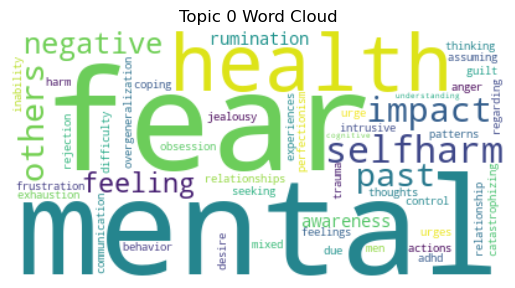

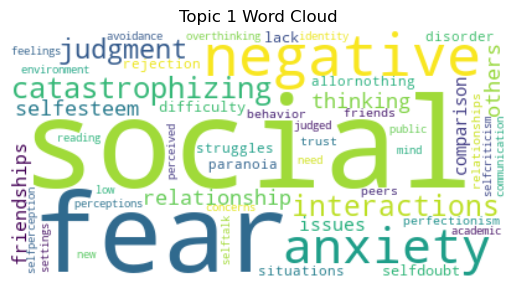

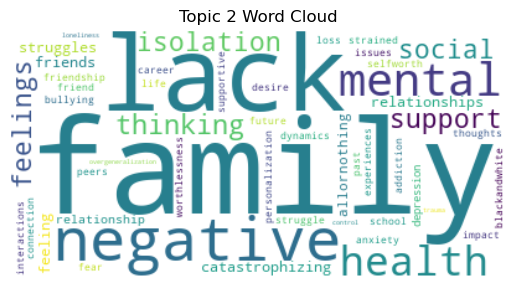

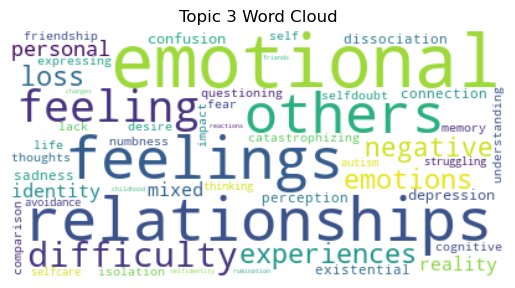

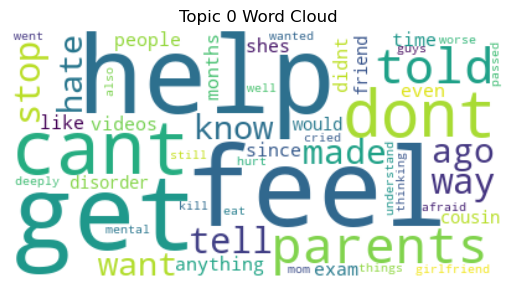

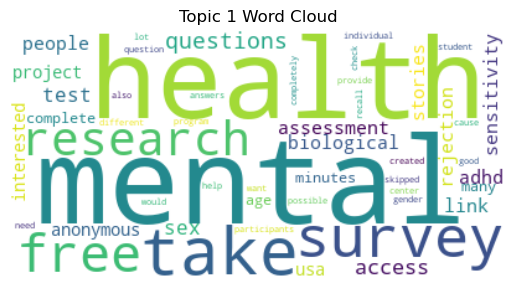

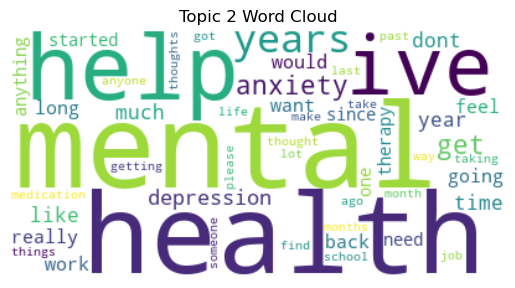

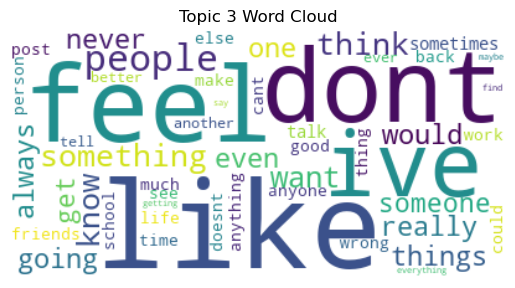

In [27]:
def plot_topic_wordcloud(lda_model, topic_num, dictionary, ax=None):
    # Get the topic as a dictionary {word: weight}
    topic = lda_model.show_topic(topic_num, topn=50)
    topic_words = dict(topic)
    wc = WordCloud(background_color='white', width=400, height=200)
    wordcloud_img = wc.generate_from_frequencies(topic_words)
    
    plt.figure()
    plt.imshow(wordcloud_img, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_num} Word Cloud")
    plt.show()
    
# Plot word clouds for first three topics of each model
for i in range(4):
    plot_topic_wordcloud(lda_structured, i, structured_dictionary)
    
for i in range(4):
    plot_topic_wordcloud(lda_baseline, i, baseline_dictionary)



### Observations

- Structured topics appear more “on target” for mental health research, using terms that directly reference mental health themes. This can make them easier to interpret clinically or align with neuroscience/psychology constructs.
- Baseline topics highlight the natural language that people actually use, which may expose more subtle personal expressions or slang but can be noisier or less obviously aligned to mental health frameworks.


From a quick look at these word clouds, we can see a difference in the types of words each approach is surfacing:

- Structured Approach (top pair of images)

      Words like “medication,” “themes,” “mental,” “health,” “concerns,” “negative,” “cognitive,” “emotion,” “anxiety,” etc.

- Baseline Approach (bottom pair of images)
     Words like “dont,” “feel,” “really,” “know,” “get,” “want,” “back,” “talk,” “better,” etc.

    These reflect more raw everyday language, typical of direct user expressions on a forum. Instead of higher-level mental health terms, you see colloquial phrases about personal experiences (“don’t feel,” “get anymore,” “know better,” etc.).

    This can capture the authentic style of how people talk about their day-to-day struggles but often lacks explicit mental health or clinical markers unless users specifically mention them.



## Representative Documents for Each Topic

For each topic in our LDA model, this cell prints a few representative documents with two pieces of information:
- The processed/structured text (used for LDA modeling)
- The original post text (for verification)

This will allow us to verify that the extracted topic represents the content of the original text.


In [28]:


def print_representative_documents_with_original(lda_model, corpus, processed_col, original_col, num_examples=3):
    """
    For each topic, prints num_examples documents with high topic probability.
    It shows both the processed text (e.g., structured_text) used for LDA and the original post (original_text)
    for verification.
    
    Parameters:
    - lda_model: trained LDA model.
    - corpus: the Gensim corpus used by the LDA model.
    - processed_col: column name in df with the processed text used for modeling.
    - original_col: column name in df with the original post.
    - num_examples: number of example documents per topic.
    """
    # Compute document-topic distributions for each document 
    doc_topic_dist = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0)
        topics = sorted(topics, key=lambda x: x[0])
        doc_topic_dist.append([prob for _, prob in topics])
    doc_topic_dist = np.array(doc_topic_dist)
    
    num_topics = lda_model.num_topics
    
    for topic in range(num_topics):
        print("=" * 80)
        print(f"Topic {topic}")
        # Get document indices sorted in descending order by topic probability
        sorted_indices = np.argsort(doc_topic_dist[:, topic])[::-1]
        
        for i in range(num_examples):
            idx = sorted_indices[i]
            prob = doc_topic_dist[idx, topic]
            print("-" * 40)
            print(f"Document Index: {idx} (Contribution of Topic {topic}: {prob:.3f})")
            print("\n**Processed Text (used in modeling):**")
            print(df[processed_col].iloc[idx])
            print("\n**Original Post:**")
            print(df[original_col].iloc[idx])
            print("-" * 40, "\n")
        print("\n")


print_representative_documents_with_original(
    lda_model=lda_structured, 
    corpus=structured_corpus, 
    processed_col='structured_text', 
    original_col='original_text', 
    num_examples=3
)


Topic 0
----------------------------------------
Document Index: 4036 (Contribution of Topic 0: 0.859)

**Processed Text (used in modeling):**
THEMES: urges for self-harm, body sensations, mental health and ADHD, impulse control EMOTION: mixed COGNITIVE: intrusive thoughts, cognitive dissonance regarding urges and actions, awareness of potential harm vs. urge to act CONCERNS: desire to understand compulsive urges, worries about mental health, feeling of isolation regarding experiences KEYWORDS: lack of understanding from peers, feeling different from others, seeking validation or explanations from others

**Original Post:**
What is this phenomenon Okay so I’ve had this casual feeling for a while now and everyone I’ve brought it up to just finds it strange or funny, but I’m genuinely curious as to what is going on with me if nobody else can relate (google didn’t help). 
But basically I’ll be chillin by myself (mood doesn’t matter), and have urges - like I just got a burst of energy, wan